In [1]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

In [2]:
sim = WavefunctionSimulator()

In [3]:
numQubit = 4
class Track:
    def __init__(self):
        self.cnt = 0

def solve_vqe(hamiltonian: PauliSum, numLayer) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    theta_init = np.random.rand(2*numQubit*numLayer) * 2 * np.pi
    
    track = Track()

    def inc(t, xk):
        t.cnt += 1

    def ansatz_energy(theta_vec):
        p = None
        p = Program()
        for j in range(numLayer):
            for i in range(numQubit):
                p += RX(theta_vec[2*numQubit * j + 2 * i], i)
                p += RZ(theta_vec[2*numQubit * j + 2 * i + 1], i)
            for i in range(numQubit - 1):
                p += CNOT(i, i + 1)

        energy = sim.expectation(p, hamiltonian).real
        return energy

    theta_answer = minimize(ansatz_energy, theta_init, method='L-BFGS-B', callback=functools.partial(inc, track)).x
    return ansatz_energy(theta_answer), track.cnt

In [4]:
def get_ground_energy(interaction_hamil, numLayer):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe(pauliop_hamil, numLayer)


In [5]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies_mean = []
vqe_ground_energies_std = []
vqe_iter_mean = []
vqe_iter_std = []

for layer in [1,2,3,4,5]:
    gelist = []
    gestdlist = []
    iterlist = []
    iterstdlist = []
    for bond_length in bond_lengths:
        geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
        description = str(round(bond_length, 2))
        h2_interaction_hamil = load_molecular_hamiltonian(geometry,
            basis,
            multiplicity,
            description,
            n_active_electrons=None,
            n_active_orbitals=None)

        gelist_temp = []
        iterlist_temp = []
        for i in range(10):
            ge, cnt = get_ground_energy(h2_interaction_hamil, layer)
            print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
            gelist_temp.append(ge)
            iterlist_temp.append(cnt)
        gelist.append(np.mean(gelist_temp))
        gestdlist.append(np.std(gelist_temp))
        iterlist.append(np.mean(iterlist_temp))
        iterstdlist.append(np.std(iterlist_temp))
        
    vqe_ground_energies_mean.append(gelist)
    vqe_ground_energies_std.append(gestdlist)
    vqe_iter_mean.append(np.mean(iterlist))
    vqe_iter_std.append(np.mean(iterstdlist))


bond length:  0.3  ground state energy:  0.20903885415206133  iteration:  13
bond length:  0.3  ground state energy:  0.20903885413759468  iteration:  12
bond length:  0.3  ground state energy:  0.20903885412700113  iteration:  12
bond length:  0.3  ground state energy:  -0.5938277645847119  iteration:  8
bond length:  0.3  ground state energy:  0.20903885427202779  iteration:  11
bond length:  0.3  ground state energy:  0.2090388541318503  iteration:  13
bond length:  0.3  ground state energy:  -0.5938277645762673  iteration:  10
bond length:  0.3  ground state energy:  -0.5938277645398851  iteration:  11
bond length:  0.3  ground state energy:  -0.5938277645847756  iteration:  8
bond length:  0.3  ground state energy:  -0.5938277645810297  iteration:  21
bond length:  0.4  ground state energy:  -0.9043613977138444  iteration:  14
bond length:  0.4  ground state energy:  -0.9043613977099472  iteration:  14
bond length:  0.4  ground state energy:  -0.904361397695851  iteration:  20
bon

bond length:  1.3  ground state energy:  -0.8552369420752493  iteration:  8
bond length:  1.3  ground state energy:  -0.8552369420604169  iteration:  10
bond length:  1.3  ground state energy:  -0.9731106135369709  iteration:  9
bond length:  1.4  ground state energy:  -0.8754279397952776  iteration:  8
bond length:  1.4  ground state energy:  -0.8754279396347906  iteration:  7
bond length:  1.4  ground state energy:  -0.9414806527827129  iteration:  16
bond length:  1.4  ground state energy:  -0.8754279399536926  iteration:  13
bond length:  1.4  ground state energy:  -0.9414806527555759  iteration:  12
bond length:  1.4  ground state energy:  -0.9414806527831654  iteration:  14
bond length:  1.4  ground state energy:  -0.8754279400532793  iteration:  9
bond length:  1.4  ground state energy:  -0.9414806525659216  iteration:  16
bond length:  1.4  ground state energy:  -0.8754279400454704  iteration:  9
bond length:  1.4  ground state energy:  -0.8754279400434343  iteration:  13
bond 

bond length:  2.4  ground state energy:  -0.9309808721493271  iteration:  9
bond length:  2.4  ground state energy:  -0.7159100589910591  iteration:  10
bond length:  2.4  ground state energy:  -0.9309808721816784  iteration:  7
bond length:  2.4  ground state energy:  -0.9309808721604551  iteration:  15
bond length:  2.4  ground state energy:  -0.9309808721818145  iteration:  15
bond length:  2.5  ground state energy:  -0.9316390867815301  iteration:  9
bond length:  2.5  ground state energy:  -0.9316390864445301  iteration:  8
bond length:  2.5  ground state energy:  -0.9316390866846676  iteration:  17
bond length:  2.5  ground state energy:  -0.594404801654193  iteration:  5
bond length:  2.5  ground state energy:  -0.9316390864135672  iteration:  8
bond length:  2.5  ground state energy:  -0.9316390866926885  iteration:  5
bond length:  2.5  ground state energy:  -0.9316390867832226  iteration:  14
bond length:  2.5  ground state energy:  -0.9316390867815155  iteration:  11
bond le

bond length:  1.2  ground state energy:  -1.0567407450428128  iteration:  16
bond length:  1.2  ground state energy:  -0.8284433471731162  iteration:  28
bond length:  1.2  ground state energy:  -0.8284433473867617  iteration:  17
bond length:  1.2  ground state energy:  -0.8284433478629799  iteration:  17
bond length:  1.2  ground state energy:  -1.05674074464047  iteration:  19
bond length:  1.2  ground state energy:  -1.0567407450657165  iteration:  23
bond length:  1.2  ground state energy:  -0.8284433476067956  iteration:  11
bond length:  1.2  ground state energy:  -0.8284433470439034  iteration:  16
bond length:  1.3  ground state energy:  -1.0351862651502601  iteration:  13
bond length:  1.3  ground state energy:  -0.8552369417384889  iteration:  15
bond length:  1.3  ground state energy:  -0.8552369412615293  iteration:  19
bond length:  1.3  ground state energy:  -1.0351862651732182  iteration:  18
bond length:  1.3  ground state energy:  -0.855236941917538  iteration:  20
bo

bond length:  2.2  ground state energy:  -0.9287736338663233  iteration:  17
bond length:  2.3  ground state energy:  -0.9300586196849505  iteration:  23
bond length:  2.3  ground state energy:  -0.9300586384960967  iteration:  17
bond length:  2.3  ground state energy:  -0.9300586385241455  iteration:  16
bond length:  2.3  ground state energy:  -0.9389223855317186  iteration:  18
bond length:  2.3  ground state energy:  -0.9300586381252475  iteration:  19
bond length:  2.3  ground state energy:  -0.9300586381813519  iteration:  17
bond length:  2.3  ground state energy:  -0.9300586385358747  iteration:  9
bond length:  2.3  ground state energy:  -0.9300586383384855  iteration:  16
bond length:  2.3  ground state energy:  -0.9300586385953888  iteration:  15
bond length:  2.3  ground state energy:  -0.9300586386217051  iteration:  15
bond length:  2.4  ground state energy:  -0.9309808720075576  iteration:  11
bond length:  2.4  ground state energy:  -0.9309808721038126  iteration:  20


bond length:  1.0  ground state energy:  -1.1011503278665453  iteration:  43
bond length:  1.0  ground state energy:  -1.1011503291719626  iteration:  20
bond length:  1.0  ground state energy:  -1.1011503284838189  iteration:  33
bond length:  1.0  ground state energy:  -1.101150328524592  iteration:  35
bond length:  1.1  ground state energy:  -1.0791929426496185  iteration:  28
bond length:  1.1  ground state energy:  -1.0791929437808598  iteration:  22
bond length:  1.1  ground state energy:  -1.079192943262536  iteration:  26
bond length:  1.1  ground state energy:  -0.7929596991704448  iteration:  17
bond length:  1.1  ground state energy:  -1.0791929404239753  iteration:  31
bond length:  1.1  ground state energy:  -0.7929596988057599  iteration:  19
bond length:  1.1  ground state energy:  -1.0791929419652613  iteration:  28
bond length:  1.1  ground state energy:  -1.0791929438347538  iteration:  28
bond length:  1.1  ground state energy:  -0.7929596988808238  iteration:  21
b

bond length:  2.1  ground state energy:  -0.9443746745503991  iteration:  90
bond length:  2.1  ground state energy:  -0.9269926919570379  iteration:  21
bond length:  2.1  ground state energy:  -0.9443746796251635  iteration:  44
bond length:  2.1  ground state energy:  -0.9443746789163854  iteration:  22
bond length:  2.1  ground state energy:  -0.9269926461731706  iteration:  47
bond length:  2.1  ground state energy:  -0.9443746739539065  iteration:  44
bond length:  2.1  ground state energy:  -0.9443746805942828  iteration:  46
bond length:  2.2  ground state energy:  -0.9412240293466912  iteration:  42
bond length:  2.2  ground state energy:  -0.9412239210621269  iteration:  59
bond length:  2.2  ground state energy:  -0.9287736327811282  iteration:  18
bond length:  2.2  ground state energy:  -0.9412240318399133  iteration:  29
bond length:  2.2  ground state energy:  -0.94122403307022  iteration:  47
bond length:  2.2  ground state energy:  -0.9287736344997273  iteration:  21
b

bond length:  0.9  ground state energy:  -1.120560277338857  iteration:  52
bond length:  0.9  ground state energy:  -1.1205602665740877  iteration:  37
bond length:  0.9  ground state energy:  -1.1205602644597965  iteration:  52
bond length:  0.9  ground state energy:  -1.1205602804293644  iteration:  36
bond length:  0.9  ground state energy:  -1.12056028021673  iteration:  53
bond length:  0.9  ground state energy:  -1.1205602647981232  iteration:  70
bond length:  0.9  ground state energy:  -1.1205602803599277  iteration:  25
bond length:  0.9  ground state energy:  -1.1205602799711298  iteration:  52
bond length:  0.9  ground state energy:  -1.1205602803707562  iteration:  32
bond length:  0.9  ground state energy:  -1.1205602748840346  iteration:  45
bond length:  1.0  ground state energy:  -1.101150327741789  iteration:  70
bond length:  1.0  ground state energy:  -1.101150329057362  iteration:  41
bond length:  1.0  ground state energy:  -1.1011503241385012  iteration:  75
bond

bond length:  1.9  ground state energy:  -0.9543388532405841  iteration:  67
bond length:  1.9  ground state energy:  -0.954338846134034  iteration:  34
bond length:  1.9  ground state energy:  -0.9543386886329506  iteration:  86
bond length:  2.0  ground state energy:  -0.948641102993908  iteration:  87
bond length:  2.0  ground state energy:  -0.9486411057530066  iteration:  106
bond length:  2.0  ground state energy:  -0.9486411094212432  iteration:  54
bond length:  2.0  ground state energy:  -0.9245373184256394  iteration:  28
bond length:  2.0  ground state energy:  -0.9486411109276643  iteration:  52
bond length:  2.0  ground state energy:  -0.948641105891254  iteration:  58
bond length:  2.0  ground state energy:  -0.9486411099055841  iteration:  49
bond length:  2.0  ground state energy:  -0.9245372716935445  iteration:  21
bond length:  2.0  ground state energy:  -0.9486411103282026  iteration:  40
bond length:  2.0  ground state energy:  -0.9245373144582005  iteration:  20
b

bond length:  0.7  ground state energy:  -1.1361894524546865  iteration:  31
bond length:  0.7  ground state energy:  -1.1361893275345143  iteration:  113
bond length:  0.7  ground state energy:  -1.1361894195949875  iteration:  102
bond length:  0.7  ground state energy:  -1.1361894530130963  iteration:  38
bond length:  0.7  ground state energy:  -1.136189448302638  iteration:  60
bond length:  0.7  ground state energy:  -1.1361889305367692  iteration:  143
bond length:  0.8  ground state energy:  -1.1341467975323405  iteration:  77
bond length:  0.8  ground state energy:  -1.1341476651812388  iteration:  33
bond length:  0.8  ground state energy:  -1.1341476613475088  iteration:  43
bond length:  0.8  ground state energy:  -1.134147482986133  iteration:  93
bond length:  0.8  ground state energy:  -1.1341476629611589  iteration:  32
bond length:  0.8  ground state energy:  -1.1341476537475057  iteration:  70
bond length:  0.8  ground state energy:  -1.1341476513826443  iteration:  8

bond length:  1.8  ground state energy:  -0.9618169321020792  iteration:  119
bond length:  1.8  ground state energy:  -0.9618167195391014  iteration:  90
bond length:  1.8  ground state energy:  -0.9618169499164706  iteration:  49
bond length:  1.8  ground state energy:  -0.961816917424602  iteration:  97
bond length:  1.8  ground state energy:  -0.9618169209537156  iteration:  128
bond length:  1.8  ground state energy:  -0.9618169470303117  iteration:  133
bond length:  1.8  ground state energy:  -0.9618169465841216  iteration:  96
bond length:  1.8  ground state energy:  -0.9618169493366231  iteration:  73
bond length:  1.8  ground state energy:  -0.9618169321645448  iteration:  72
bond length:  1.9  ground state energy:  -0.9211703455896245  iteration:  43
bond length:  1.9  ground state energy:  -0.9543384025819378  iteration:  59
bond length:  1.9  ground state energy:  -0.9543388523236486  iteration:  54
bond length:  1.9  ground state energy:  -0.9543388217467164  iteration:  

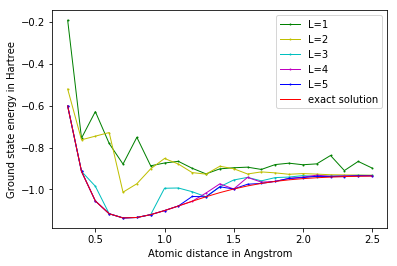

In [81]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies += [molecule.fci_energy]
    hf_energies += [molecule.hf_energy]

plt.figure(0)
plt.plot(bond_lengths, vqe_ground_energies_mean[0], 'go-', linewidth=1, markersize=1, label='L=1')
plt.plot(bond_lengths, vqe_ground_energies_mean[1], 'yo-', linewidth=1, markersize=1, label='L=2')
plt.plot(bond_lengths, vqe_ground_energies_mean[2], 'co-', linewidth=1, markersize=1, label='L=3')
plt.plot(bond_lengths, vqe_ground_energies_mean[3], 'mo-', linewidth=1, markersize=1, label='L=4')
plt.plot(bond_lengths, vqe_ground_energies_mean[4], 'bo-', linewidth=1, markersize=1, label='L=5')
plt.plot(bond_lengths, fci_energies, 'r-', linewidth=1, markersize=1, label='exact solution')
plt.legend()
plt.ylabel('Ground state energy in Hartree')
plt.xlabel('Atomic distance in Angstrom')
plt.savefig('PLOT1.pdf', bbox_inches='tight')
plt.show()

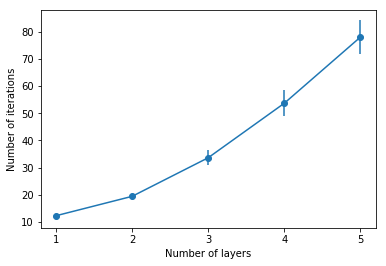

[0.8292957348318495, 0.8908153515697075, 0.9790360256548184, 0.9936606154747886, 0.9963996655655551]
[-0.03043206795040988, -0.024555662871677746, -0.007321613621232735, -0.0020469549264236116, -0.0017055555186289918]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


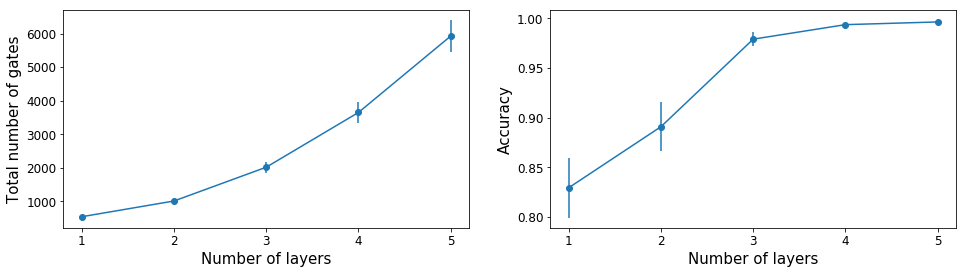

In [80]:
#plt.plot([1,2,3,4,5], vqe_iter_mean, 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.errorbar([1,2,3,4,5], vqe_iter_mean, vqe_iter_std/np.sqrt(23), marker='o', linestyle=None)
plt.ylabel('Number of iterations')
plt.xlabel('Number of layers')
plt.show()

f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
plt.xticks(np.arange(0, 6, step=1))
ax.tick_params(labelsize = 12)
numGates = 36+8*np.array([1,2,3,4,5])
totalNumGates = np.array(vqe_iter_mean)*numGates
ax.errorbar([1,2,3,4,5], totalNumGates, vqe_iter_std/np.sqrt(23)*numGates, marker='o', linestyle=None)
plt.ylabel('Total number of gates', size=15)
plt.xlabel('Number of layers', size=15)

accuracy = []
error = []
for i in range(5):
    acc = 1-np.abs(np.mean((np.array(vqe_ground_energies_mean[i])-np.array(fci_energies))/np.array(fci_energies)))
    err = np.mean(vqe_ground_energies_std[i]/np.array(fci_energies))/np.sqrt(23)
    accuracy.append(acc)
    error.append(err)
print(accuracy)
print(error)
ax2 = f.add_subplot(122)
plt.xticks(np.arange(0, 6, step=1))
plt.yticks(np.arange(0.8, 1.05, step = 0.05))
ax2.tick_params(labelsize = 12)
ax2.errorbar([1,2,3,4,5], accuracy, error, marker='o')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Number of layers', size=15)

f.show()
f.savefig('PLOT2.pdf', bbox_inches='tight')


[0.8292957348318495, 0.8908153515697075, 0.9790360256548184, 0.9936606154747886, 0.9963996655655551]
[-0.03043206795040988, -0.024555662871677746, -0.007321613621232735, -0.0020469549264236116, -0.0017055555186289918]


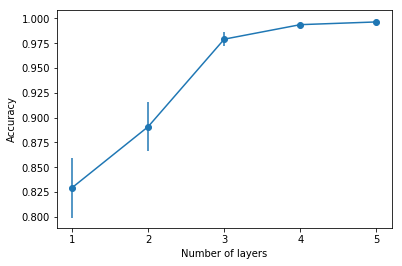

In [54]:
accuracy = []
error = []
for i in range(5):
    acc = 1-np.abs(np.mean((np.array(vqe_ground_energies_mean[i])-np.array(fci_energies))/np.array(fci_energies)))
    err = np.mean(vqe_ground_energies_std[i]/np.array(fci_energies))/np.sqrt(23)
    accuracy.append(acc)
    error.append(err)
print(accuracy)
print(error)
plt.xticks(np.arange(0, 6, step=1))
plt.errorbar([1,2,3,4,5], accuracy, error, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Number of layers')
plt.show()

In [30]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
layer=4

gelist_layer4 = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)

    gelist_temp = []
    for i in range(10):
        ge, cnt = get_ground_energy(h2_interaction_hamil, layer)
        print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
        gelist_temp.append(ge)
    gelist_layer4.append(min(gelist_temp))
        
print(gelist_layer4)

bond length:  0.3  ground state energy:  -0.601803716745519  iteration:  50
bond length:  0.3  ground state energy:  -0.6018037150718262  iteration:  36
bond length:  0.3  ground state energy:  -0.6018037163349372  iteration:  33
bond length:  0.3  ground state energy:  -0.6018037160632721  iteration:  42
bond length:  0.3  ground state energy:  -0.6018037133499453  iteration:  48
bond length:  0.3  ground state energy:  -0.6018037163209089  iteration:  44
bond length:  0.3  ground state energy:  -0.6018037167006471  iteration:  28
bond length:  0.3  ground state energy:  -0.6018037121454229  iteration:  64
bond length:  0.3  ground state energy:  -0.6018037100143121  iteration:  53
bond length:  0.3  ground state energy:  -0.6018037142628473  iteration:  35
bond length:  0.4  ground state energy:  -0.9141497080315906  iteration:  42
bond length:  0.4  ground state energy:  -0.9141497074520964  iteration:  36
bond length:  0.4  ground state energy:  -0.9141495003599979  iteration:  113

bond length:  1.3  ground state energy:  -0.9452116019962314  iteration:  34
bond length:  1.3  ground state energy:  -1.0351862573288897  iteration:  32
bond length:  1.3  ground state energy:  -1.0351862646872783  iteration:  44
bond length:  1.4  ground state energy:  -1.0154682438944538  iteration:  45
bond length:  1.4  ground state energy:  -1.015468213640319  iteration:  31
bond length:  1.4  ground state energy:  -1.0154682420791203  iteration:  60
bond length:  1.4  ground state energy:  -1.0154682446889678  iteration:  60
bond length:  1.4  ground state energy:  -1.015468243797469  iteration:  70
bond length:  1.4  ground state energy:  -1.0154682451710395  iteration:  49
bond length:  1.4  ground state energy:  -1.015468244744815  iteration:  41
bond length:  1.4  ground state energy:  -1.015468245383837  iteration:  72
bond length:  1.4  ground state energy:  -1.0154682399846717  iteration:  27
bond length:  1.4  ground state energy:  -1.0154682376301771  iteration:  71
bon

bond length:  2.4  ground state energy:  -0.9309808698957015  iteration:  32
bond length:  2.4  ground state energy:  -0.9372545004529687  iteration:  89
bond length:  2.4  ground state energy:  -0.9372547633251008  iteration:  112
bond length:  2.4  ground state energy:  -0.9372549485194255  iteration:  89
bond length:  2.4  ground state energy:  -0.9372546122564795  iteration:  55
bond length:  2.4  ground state energy:  -0.9372549501160172  iteration:  100
bond length:  2.5  ground state energy:  -0.9316390853890861  iteration:  41
bond length:  2.5  ground state energy:  -0.936054669298372  iteration:  91
bond length:  2.5  ground state energy:  -0.9360548706376669  iteration:  114
bond length:  2.5  ground state energy:  -0.9316390579607687  iteration:  61
bond length:  2.5  ground state energy:  -0.9316391404557065  iteration:  37
bond length:  2.5  ground state energy:  -0.9360547896722964  iteration:  144
bond length:  2.5  ground state energy:  -0.9316390858002062  iteration: 

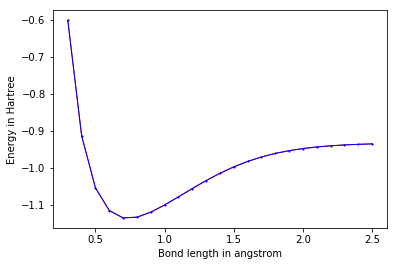

In [31]:
plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'rx-', linewidth=1, markersize=1)
plt.plot(bond_lengths, gelist_layer4, 'bo-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [32]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
layer=3

gelist_layer3 = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)

    gelist_temp = []
    for i in range(10):
        ge, cnt = get_ground_energy(h2_interaction_hamil, layer)
        print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
        gelist_temp.append(ge)
    gelist_layer3.append(min(gelist_temp))
        
print(gelist_layer3)

bond length:  0.3  ground state energy:  -0.6018037167446546  iteration:  25
bond length:  0.3  ground state energy:  -0.601803716737493  iteration:  27
bond length:  0.3  ground state energy:  -0.6018037140910953  iteration:  51
bond length:  0.3  ground state energy:  -0.6018037163919596  iteration:  29
bond length:  0.3  ground state energy:  -0.6018037166492078  iteration:  29
bond length:  0.3  ground state energy:  -0.6018037157053356  iteration:  42
bond length:  0.3  ground state energy:  0.2090388544236262  iteration:  28
bond length:  0.3  ground state energy:  -0.601803716768704  iteration:  21
bond length:  0.3  ground state energy:  -0.6018037167952148  iteration:  37
bond length:  0.3  ground state energy:  -0.6018037128209759  iteration:  45
bond length:  0.4  ground state energy:  -0.9141497051598952  iteration:  40
bond length:  0.4  ground state energy:  -0.9141497076910756  iteration:  34
bond length:  0.4  ground state energy:  -0.9141497068815725  iteration:  46
bo

bond length:  1.3  ground state energy:  -1.0351862640908913  iteration:  32
bond length:  1.3  ground state energy:  -1.0351862557258742  iteration:  31
bond length:  1.3  ground state energy:  -0.855236941814544  iteration:  32
bond length:  1.4  ground state energy:  -1.015468247448274  iteration:  34
bond length:  1.4  ground state energy:  -1.0154682473306724  iteration:  25
bond length:  1.4  ground state energy:  -1.0154682477591266  iteration:  31
bond length:  1.4  ground state energy:  -0.8754279252423627  iteration:  32
bond length:  1.4  ground state energy:  -0.8754279399284987  iteration:  12
bond length:  1.4  ground state energy:  -1.0154682465656968  iteration:  19
bond length:  1.4  ground state energy:  -1.0154682479284647  iteration:  27
bond length:  1.4  ground state energy:  -1.0154682433025355  iteration:  35
bond length:  1.4  ground state energy:  -1.0154682476872958  iteration:  36
bond length:  1.4  ground state energy:  -0.8754277333899279  iteration:  26
b

bond length:  2.4  ground state energy:  -0.9309808721406809  iteration:  21
bond length:  2.4  ground state energy:  -0.9341189405311134  iteration:  46
bond length:  2.4  ground state energy:  -0.9372549510525606  iteration:  30
bond length:  2.4  ground state energy:  -0.9309808678585276  iteration:  33
bond length:  2.4  ground state energy:  -0.9309808709269108  iteration:  28
bond length:  2.4  ground state energy:  -0.9309808616613123  iteration:  28
bond length:  2.5  ground state energy:  -0.9360549193903076  iteration:  72
bond length:  2.5  ground state energy:  -0.9316390862624718  iteration:  22
bond length:  2.5  ground state energy:  -0.9338496966471932  iteration:  24
bond length:  2.5  ground state energy:  -0.9360549194804542  iteration:  61
bond length:  2.5  ground state energy:  -0.9316390864722615  iteration:  15
bond length:  2.5  ground state energy:  -0.9316390849888985  iteration:  16
bond length:  2.5  ground state energy:  -0.9360549181049089  iteration:  74

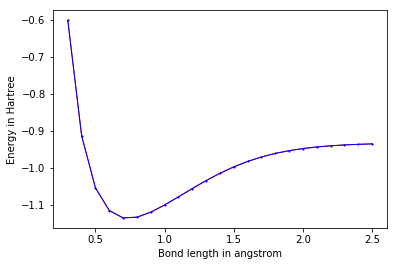

In [33]:
plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'rx-', linewidth=1, markersize=1)
plt.plot(bond_lengths, gelist_layer3, 'bo-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()